# CS 135 day18: Bootstrap samples and Random Forests

# Objectives

* Understand bootstrap samples of data.
* Learn how to use *probabilistic* random forest classifiers in sklearn

* See tradeoffs in RFs as a function of different hyperparameters
* * max_features : Number of features considered at each decision node when finding the best split
* * max_depth
* * min_samples_per_leaf

We'll reuse the same examples from our experience with Logistic Regression and kNN to provide some common ground

# Outline

* [Part 1: Bootstrap samples](#part1)
* [Part 2: Binary classification with Random Forests on 1-dim. toy example](#part2)
* [Part 3: Visualizing decision boundaries of Decision Trees on 2-dim. features](#part3)

We expect you'll get through part 3 during this class period. 

# Takeaways for Part 1
 
* The bootstrap is a simple procedure for drawing other datasets that are "similar" to your original (plausibly from same empirical distribution)
* The limiting probability that each example is included in a bootstrap sample has a nice closed form (related to $e$)

# Takeaways for Part 2-3

* Random forests offer smoother, more flexible decision boundaries than a single decision tree
* Adding more trees will usually strictly improve the performance (albeit at increased computation cost), until you saturate at some plateau
* Adjusting hyperparameters like max_depth can help manage overfitting even in RandomForests

In [ ]:
import numpy as np

In [ ]:
import sklearn.tree
import sklearn.ensemble


In [ ]:
# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

# Part 1: The Bootstrap

Credit to ISL textbook Sec. 5.4 for inspiring this content.

Recall that a bootstrap sample $\mathcal{S}$ for a dataset $\{x_n\}_{n=1}^N$ of size $N$ is obtained, by

```
INPUT: x[n] for n in 1, 2, ... N

initialize empty set S
for n in 1, 2, ... N:
    i <- draw_int_from_uniform( low=1, high=N)
    add x[i] to S
```

### Simple for loop implementation of bootstrap

In [ ]:
def draw_bootstrap_dataset_forloop(x_N, random_state=0):
    if isinstance(random_state, int):
        random_state = np.random.RandomState(int(random_state))

    N = x_N.shape[0]
    xboot_N = np.zeros(x_N.shape) # create empty array of desired size (same as input)
    for n in range(N):
        i = random_state.randint(low=0, high=N)
        xboot_N[n] = x_N[i]
    return xboot_N

### Demonstration: Show 10 different bootstrap samples of an N=3 dataset

In [ ]:
xorig_N = np.asarray([0, 1, 2])

In [ ]:
for i in range(10):
    xboot_N = draw_bootstrap_dataset_forloop(xorig_N, random_state=i) # be sure to use a different seed for each sample
    print("sample %d:\n    %s" % (i, str(xboot_N)))

sample 0:
    [0. 1. 0.]
sample 1:
    [1. 0. 0.]
sample 2:
    [0. 1. 0.]
sample 3:
    [2. 0. 1.]
sample 4:
    [2. 2. 1.]
sample 5:
    [2. 1. 2.]
sample 6:
    [2. 1. 0.]
sample 7:
    [0. 1. 2.]
sample 8:
    [0. 1. 1.]
sample 9:
    [2. 0. 2.]


### Demo: We can also draw samples when each example has multiple features

Create a dataset with N rows and 2 columns (e.g. each example has a feature vector of size F=2)

In [ ]:
xorig_N2 = np.asarray([[1, 1], [2, 2], [3, 3]])
print(xorig_N2)

[[1 1]
 [2 2]
 [3 3]]


Here is one bootstrap sample!

In [ ]:
draw_bootstrap_dataset_forloop(xorig_N2)

array([[1., 1.],
       [2., 2.],
       [1., 1.]])

### Exercise 1a: Show 10 different bootstrap samples for dataset with N=3 and F =2

In [ ]:
for i in range(10):
    # TODO draw bootstrap sample of data in array xorig_N2 with seed i
    print("sample %d:\n    %s" % (i, 'todo'))

sample 0:
    todo
sample 1:
    todo
sample 2:
    todo
sample 3:
    todo
sample 4:
    todo
sample 5:
    todo
sample 6:
    todo
sample 7:
    todo
sample 8:
    todo
sample 9:
    todo


### Exercise 1c: Some math problems

- What is the probability that when N=1, your bootstrap sample does not contain the first item in original dataset?
- What is the probability that when N=2, your bootstrap sample does not contain the first item in original dataset?
- What is the probability that when N=3, your bootstrap sample does not contain the first item in original dataset?
- What is the probability that when N=5, your bootstrap sample does not contain the first item in original dataset?

In [ ]:
# TODO write answer here

### Discussion 1d: Argue why the following is true:

Given a large dataset of size $N$, the probability your bootstrap sample does NOT contain any single item $x_i$ in the original dataset is:

$$
p( x_i \notin S ) = \left(1 - \frac{1}{N} \right)^N
$$


In [ ]:
# TODO write answer here

### Exercise 1e: Create a plot showing this probability from 1d as $N$ varies from 100 to 50000 (step by 100)

What is the limiting value of this expression? Can you express it in terms of the natural number $e$?

In [ ]:
N_grid = np.arange(100, 50000, 100)
p_grid = np.zeros(N_grid.size) # TODO fill entries of p using formula above in 1d

[<matplotlib.lines.Line2D>]

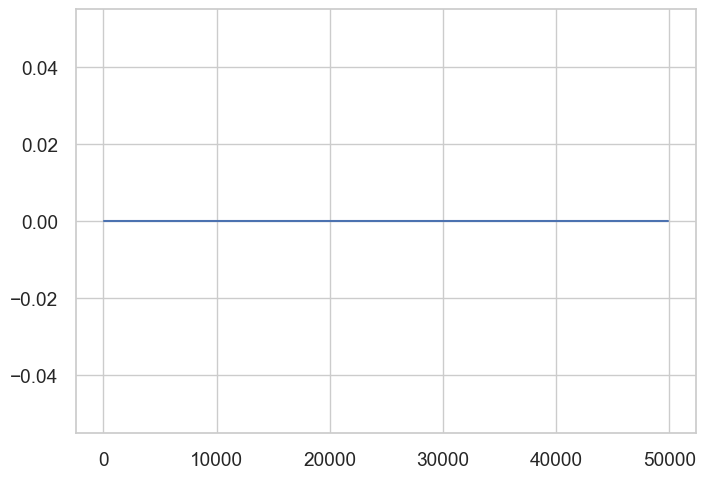

In [ ]:
plt.plot(N_grid, p_grid)

### Vectorized implementation of bootstrap

This is a much faster implementation (no for loops!)

But it is the *same* as the one above in terms of the distribution it samples from.

In [ ]:
def draw_bootstrap_dataset_vectorized(x_N, random_state=0):
    if isinstance(random_state, int):
        random_state = np.random.RandomState(int(random_state))
    N = x_N.shape[0]
    row_ids = random_state.choice(np.arange(N), size=N, replace=True)
    return x_N[row_ids].copy()

# Setup for Part 2

### Setting up a simple classification task with 1-dim features

Let's think about a classification task where:

Each input is just scalar $x$ between -1 and +1.

The "true" label assignment function is as follows:

$$
y(x) = \begin{cases} 
1 & \text{if} ~ x > 0 \\
0 & \text{otherwise}
\end{cases}
$$

The true labeling process also has some noise: after assigning a label with the above function, each example has a ~15% chance of the opposite label. 

This noise makes our classification interesting. The "best case" error rate is about ~15%.

### Make training set for 1-dim. toy example

In [ ]:
# We generated this training set for you.

N = 12

x_tr_N = np.asarray([
    -0.975, -0.825, -0.603, -0.378, -0.284, -0.102,
     0.169,  0.311,  0.431,  0.663,  0.795,  0.976])
x_tr_N1 = x_tr_N.reshape((N,1)) # need an (N,1) shaped array for later use with sklearn

y_tr_N = np.asarray([0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1])

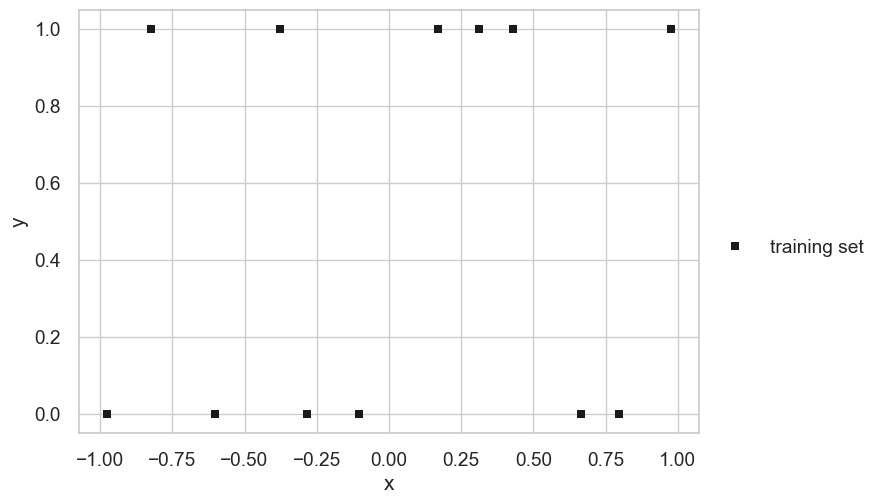

In [ ]:
plt.plot(x_tr_N, y_tr_N, 'ks', label='training set');
plt.xlabel('x');
plt.ylabel('y');
plt.legend(bbox_to_anchor=(1.0, 0.5));

# Part 2: Train random forest for F=1 data

See the docs for RandomForestClassifier here: <https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html>


In [ ]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=6)
tree.fit(x_tr_N1, y_tr_N);

### Train a forest with *5* trees

Each tree will use a *different* bootstrap sample of your dataset

In [ ]:
forest5 = sklearn.ensemble.RandomForestClassifier(bootstrap=True, max_depth=6, n_estimators=5);
forest5.fit(x_tr_N1, y_tr_N);

### Train a forest with *100* trees

Each tree will use a *different* bootstrap sample of your dataset

In [ ]:
forest100 = sklearn.ensemble.RandomForestClassifier(bootstrap=True, max_depth=6, n_estimators=100);
forest100.fit(x_tr_N1, y_tr_N);

### Make predictions using our tree using `predict_proba`

Remember, `predict_proba()` returns the probabilities of ALL possible labels: 0 and 1

There will be two columns, one for each label.

The first column is for the class corresponding to binary label 0.
The second column is for the class corresponding to binary label 1.

## Setup : Prepare for a plot over dense grid of inputs

In [ ]:
# Create dense grid of L input examples from -1.5 to 1.5
# so we can better understand the learned predictions
L = 101
dense_x_L1 = np.linspace(-1.5, 1.5, L).reshape((L,1))

## Plot: predicted probabilities vs. feature value

We can see that the predicted probabilities from Decision Trees are *piecewise constant*.

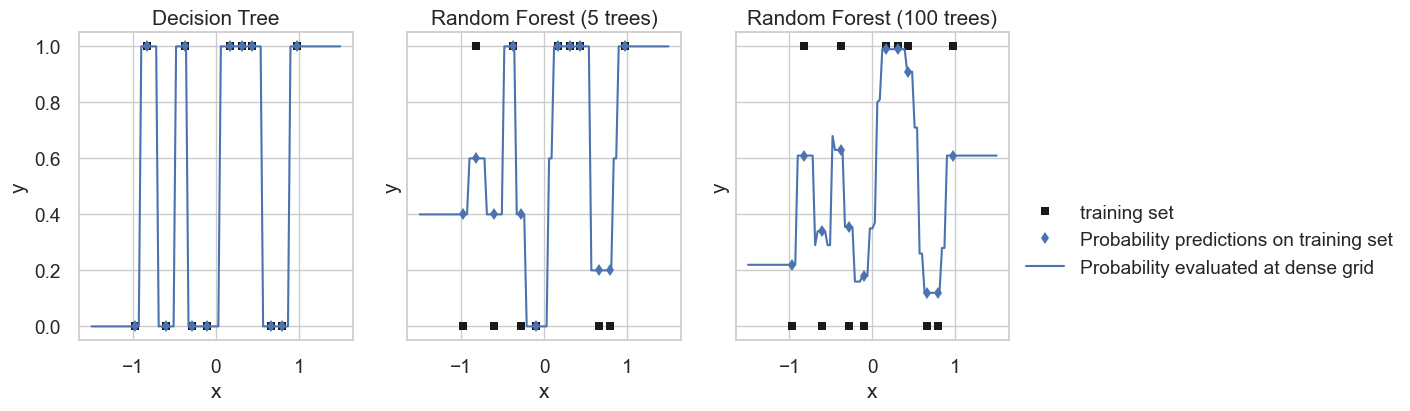

In [ ]:
fig, ax_grid = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(12,4));

for mm, (method_name, classifier) in enumerate([
            ('Decision Tree', tree),
            ('Random Forest (5 trees)', forest5),
            ('Random Forest (100 trees)', forest100),
            ]):
    plt.sca(ax_grid[mm])
    plt.plot(x_tr_N, y_tr_N, 'ks', label='training set');

    yproba1_N = classifier.predict_proba(x_tr_N1)[:,1]
    plt.plot(x_tr_N, yproba1_N, 'bd', label='Probability predictions on training set');

    # Apply our trained tree to make predictions along this grid
    # Uses the syntax [:,1] to access the column with index 1 (so we only get the probas for positive class)
    yproba1_dense_L = classifier.predict_proba(dense_x_L1)[:,1]
    plt.plot(dense_x_L1, yproba1_dense_L, 'b-', label='Probability evaluated at dense grid')

    plt.xlabel('x');
    plt.ylabel('y');
    if mm == ax_grid.size - 1:
        plt.legend(bbox_to_anchor=(1.0, 0.5));
    plt.title("%s" % method_name);

## Discussion 2a: What changes about the predicted probabilities x=0 as you add more trees? Why? 

## Discussion 2b: What value does the predicted probability take at x=1.5, as we include more and more trees? Can you argue about why it takes this value?

* Hint 1: What is the probability that any single bootstrap sample includes the data point with largest $x$ value?
* Hint 2: Given *this* training set, what will a single decision tree tend to predict if it includes this point, vs. if it doesnt?

## Discussion 2c: What do you think would happen if we used 1000 trees or 1 million trees?

# Setup for Part 3

### Define simple dataset of points in 2D space

Don't worry about the details of this setup.
Just try to understand the plots below.

In [ ]:
def create_2d_dataset(N=100, noise_stddev=0.25, random_state=0):
    random_state = np.random.RandomState(int(random_state))

    mA_2 = np.asarray([1, 0])
    covA_22 = np.square(noise_stddev) * np.eye(2)
    
    mB_2 = np.asarray([0, 0])
    covB_22 = np.square(noise_stddev) * np.eye(2)

    mC_2 = np.asarray([0, 1])
    covC_22 = np.square(noise_stddev) * np.eye(2)

    # Draw data from 3 "Gaussian" blobs
    xA_N2 = random_state.multivariate_normal(mA_2, covA_22, size=N)
    xB_N2 = random_state.multivariate_normal(mB_2, covB_22, size=N)
    xC_N2 = random_state.multivariate_normal(mC_2, covC_22, size=N)

    x_N2 = np.vstack([xA_N2, xB_N2, xC_N2])
    y_N = np.hstack([np.ones(xA_N2.shape[0]), np.zeros(xB_N2.shape[0]), np.ones(xC_N2.shape[0])])
    
    return x_N2, y_N

## Create training and validation datasets with 100 points per class

In [ ]:
x_tr_N2, y_tr_N = create_2d_dataset(N=100, random_state=101);

In [ ]:
x_va_N2, y_va_N = create_2d_dataset(N=100, random_state=202);

### Define function to plot data as scatterpoints in 2d

In [ ]:
def plot_pretty_data_colored_by_labels(x_N2, y_N):
    plt.plot(x_N2[y_N==0,0], x_N2[y_N==0,1], color='r', marker='x', linestyle='', markersize=5, mew=2, label='y=0');
    plt.plot(x_N2[y_N==1,0], x_N2[y_N==1,1], color='b', marker='+', linestyle='', markersize=8, mew=2, label='y=1');

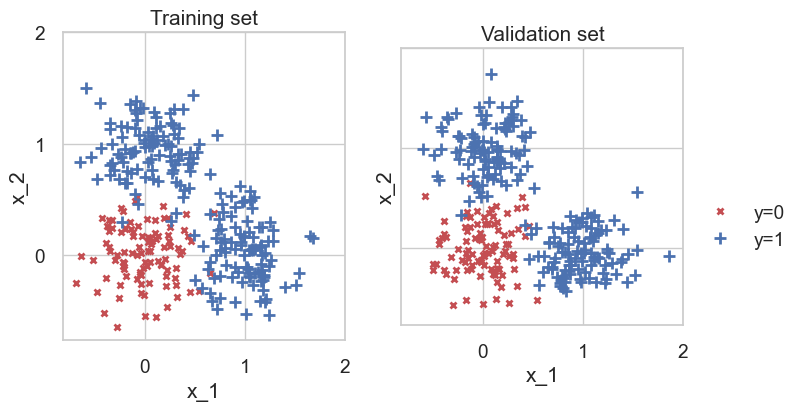

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4), sharex=True, sharey=True)

plt.sca(ax[0])
plot_pretty_data_colored_by_labels(x_tr_N2, y_tr_N);
plt.title("Training set");
plt.xlabel('x_1');
plt.ylabel('x_2');

plt.sca(ax[1])
plot_pretty_data_colored_by_labels(x_va_N2, y_va_N);
plt.title("Validation set");
plt.xlabel('x_1');
plt.ylabel('x_2');

plt.legend(bbox_to_anchor=(1.0, 0.5));
plt.gca().set_aspect(1.0);
plt.xticks([0, 1, 2]);
plt.yticks([0, 1, 2]);


### Define function to make pretty plots of predicted probability color fields

You don't need to understand this in detail. Just a utility function.

In [ ]:
def plot_pretty_probabilities_for_clf(
        clf,
        do_show_colorbar=False,
        x1_ticks=np.asarray([0, 2, 4]),
        x2_ticks=np.asarray([0, 2, 4]),
        c_levels=np.linspace(0, 1, 100),
        c_ticks=np.asarray([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        x1_grid=np.linspace(-1, 2.3, 100),
        x2_grid=np.linspace(-1, 2.3, 100)):
    cur_ax = plt.gca()
    
    G = x1_grid.size
    H = x2_grid.size
    
    # Get regular grid of G x H points, where each point is an (x1, x2) location
    x1_GH, x2_GH = np.meshgrid(x1_grid, x2_grid)
    
    # Combine the x1 and x2 values into one array
    # Flattened into M = G x H rows
    # Each row of x_M2 is a 2D vector [x_m1, x_m2]
    x_M2 = np.hstack([x1_GH.flatten()[:,np.newaxis], x2_GH.flatten()[:,np.newaxis]])
    
    # Predict proba for each point in the flattened grid
    yproba1_M = clf.predict_proba(x_M2)[:,1]
    
    # Reshape the M probas into the GxH 2D field
    yproba1_GH = np.reshape(yproba1_M, x1_GH.shape)
    
    cmap = plt.cm.RdYlBu
    my_contourf_h = plt.contourf(x1_GH, x2_GH, yproba1_GH, levels=c_levels, vmin=0, vmax=1.0, cmap=cmap)
    
    plt.xticks(x1_ticks, x1_ticks);
    plt.yticks(x2_ticks, x2_ticks);
    
    if do_show_colorbar:
        left, bottom, width, height = plt.gca().get_position().bounds
        cax = plt.gcf().add_axes([left+1.1*width, bottom, 0.03, height])
        plt.colorbar(my_contourf_h, orientation='vertical', cax=cax, ticks=c_ticks);
        plt.sca(cur_ax);

# Part 3: Visualization of RandomForest predictions as we vary max_depth

Generally, max depth is one of the key hyperparameters that controls model complexity of decision trees.

What about for random forests? Do the models change visibly?

## From last time: DecisionTree learned decision boundaries 

Looking at the learned classification probabilities as a function of the features

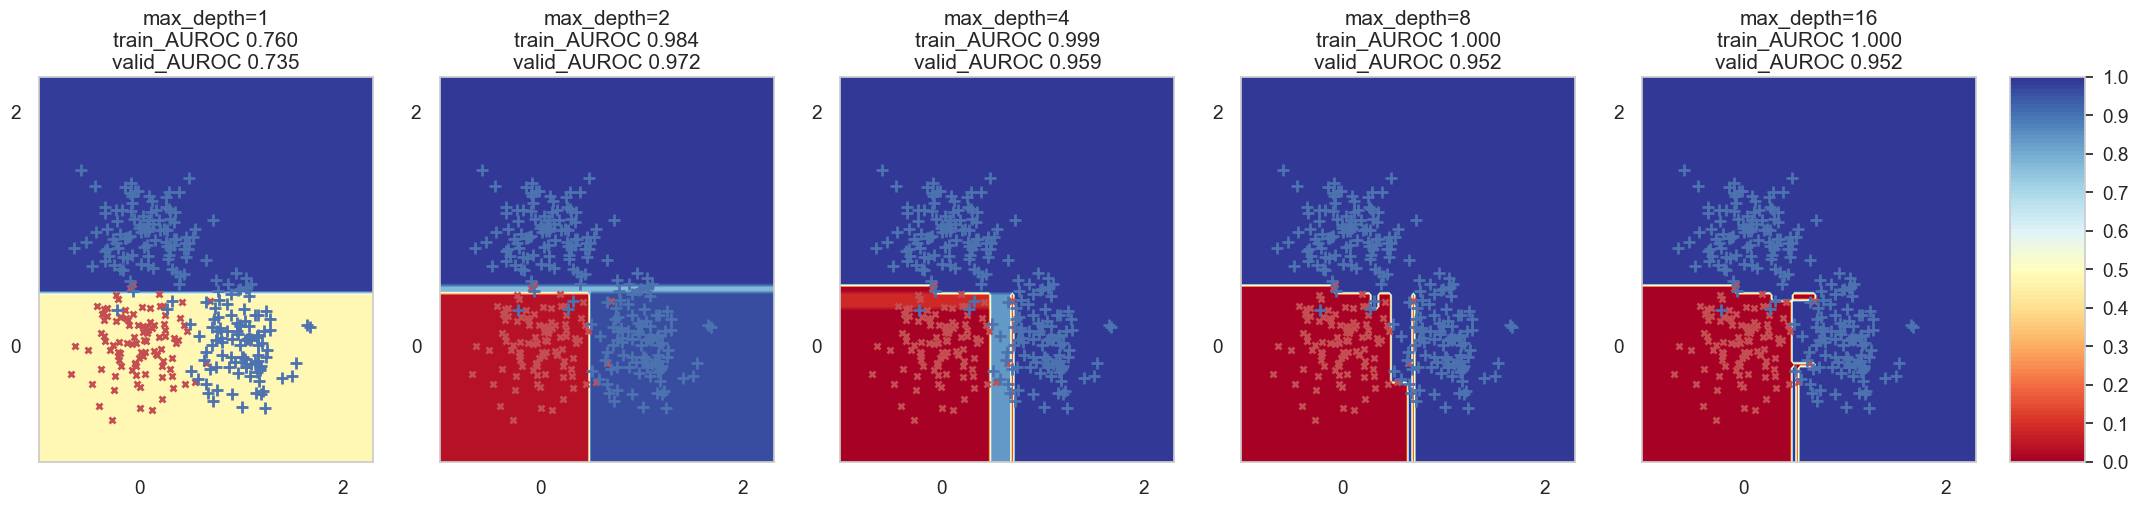

In [ ]:
max_depth_grid = [1, 2, 4, 8, 16]

trees_by_depth = dict()

ncols = len(max_depth_grid)
fig_h, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(5 * ncols, 5))

is_last = False
for ii, max_depth in enumerate(max_depth_grid):
    if ii == ncols - 1:
        is_last = True
    plt.sca(axes[ii])
    clf = sklearn.tree.DecisionTreeClassifier(max_depth=max_depth)
    clf.fit(x_tr_N2, y_tr_N)

    plot_pretty_probabilities_for_clf(clf, do_show_colorbar=is_last);
    plot_pretty_data_colored_by_labels(x_tr_N2, y_tr_N);
    
    tr_auroc = sklearn.metrics.roc_auc_score(y_tr_N, clf.predict_proba(x_tr_N2)[:,1])
    va_auroc = sklearn.metrics.roc_auc_score(y_va_N, clf.predict_proba(x_va_N2)[:,1])
    
    plt.title("max_depth=%d\ntrain_AUROC %.3f\nvalid_AUROC %.3f" % (max_depth, tr_auroc, va_auroc))
    
    # Store for later
    trees_by_depth[max_depth] = clf

## Discussion 2a: What depth would you pick to generalize well to new data? You can use the area under the roc curve (AUROC).

## New today: Random forest with 25 trees and max_features=1

Looking at the learned classification probabilities as a function of the features

Compare with the above.

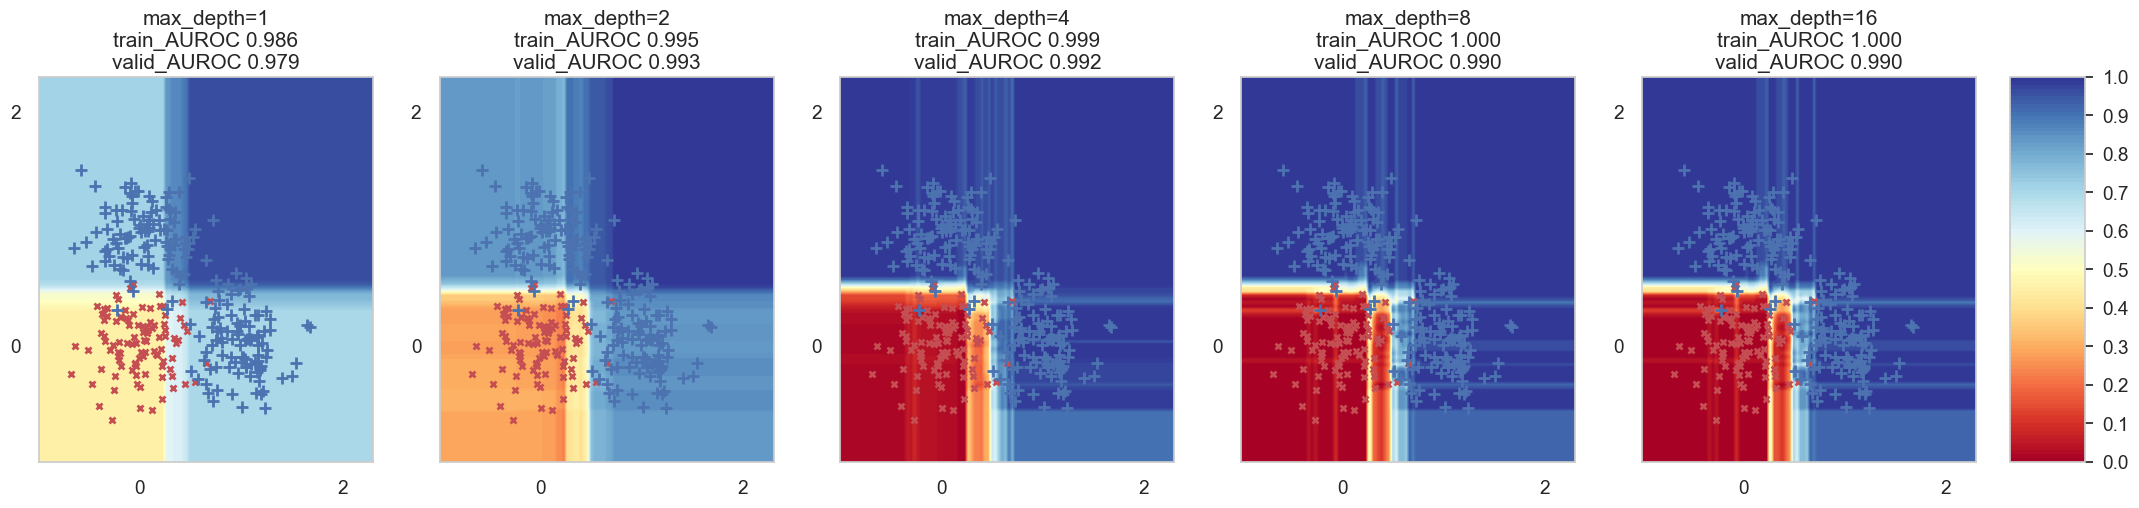

In [ ]:
max_depth_grid = [1, 2, 4, 8, 16]

trees_by_depth = dict()

ncols = len(max_depth_grid)
fig_h, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(5 * ncols, 5))

is_last = False
for ii, max_depth in enumerate(max_depth_grid):
    if ii == ncols - 1:
        is_last = True
    plt.sca(axes[ii])
    clf = sklearn.ensemble.RandomForestClassifier(
        max_depth=max_depth, n_estimators=25, bootstrap=True, max_features=1, random_state=101)
    clf.fit(x_tr_N2, y_tr_N)

    plot_pretty_probabilities_for_clf(clf, do_show_colorbar=is_last);
    plot_pretty_data_colored_by_labels(x_tr_N2, y_tr_N);
    
    tr_auroc = sklearn.metrics.roc_auc_score(y_tr_N, clf.predict_proba(x_tr_N2)[:,1])
    va_auroc = sklearn.metrics.roc_auc_score(y_va_N, clf.predict_proba(x_va_N2)[:,1])
    
    plt.title("max_depth=%d\ntrain_AUROC %.3f\nvalid_AUROC %.3f" % (max_depth, tr_auroc, va_auroc))


## Discussion 2b: What are the biggest changes in the qualitative appearance of the predicted probabilities for this RandomForest compared to the DecisionTree above? 

* Are there changes only for some depths?

## Discussion 2c: What depth would you pick if you wanted to generalize well to new data? (Again you can use the AUROC on validation). Does it seem as sensitive as it does in the DecisionTreeClassifier? 

## Discussion 2d: Do you see any signs of overfitting? If so, is it mild or severe?